In [3]:
import json
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio
import rioxarray as rxr
import numpy as np
import os
import regionmask
from collections import Counter
import shapely.geometry

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import ee
import geemap
import json
from collections import Counter
from shapely.geometry import Point

import warnings

warnings.filterwarnings('ignore')

ee.Authenticate()
ee.Initialize(project='deepcarbon')

ModuleNotFoundError: No module named 'geopandas'

In [2]:
!pip install geopandas

In [10]:
shape = gpd.read_file('./data/shp_bdry_census2020counties_ctus/Census2020Counties.shp').to_crs(4326)
shape = shape[shape['CO_NAME_FU']=='Hennepin County']

# MLCCS

In [9]:
lc = gpd.read_file('./data/shp_biota_landcover_mlccs/landcover_minnesota_land_cover_classification_system.shp').to_crs(4326)
hennepin = gpd.clip(lc, shape[shape['CO_NAME_FU']=='Hennepin County']).reset_index(drop=True)
classes = dict(zip([0, 11,12,13,14,15,21,22,23,24,31,32,51,52,61,62,63,71,81,82,90,92], ['Not Classified',
'5-10% Impervious', '11-25% Impervious', '26-50% Impervious', 
    '51-75% Impervious', '76-100% Impervious', 'Short Grasses', 'Agricultural Land',
    'Maintained Tall Grass', 'Tree Plantation', 'Forest', 'Wetland Forest', 'Shrubland',
    'Wetland Shrubs', 'Tall Grasses', 'Wetland Emergent Veg.', 'Dry Tall Grasses',  'Lichen Scrubland',
    'Rock Outcrop', 'Mud Flat','Open Water', 'Wetland Open Water',
    ]))
new_clusters = {
    'Not Classified': None,
    '5-10% Impervious': 'Sparsely vegetated',
    '11-25% Impervious': 'Sparsely vegetated',
    '26-50% Impervious': 'Urban',
    '51-75% Impervious': 'Urban',
    '76-100% Impervious': 'Urban',
    'Short Grasses': 'Heathland',
    'Agricultural Land': 'Agro',
    'Maintained Tall Grass': 'Grassland',
    'Tree Plantation': 'Forest',
    'Forest': 'Forest',
    'Wetland Forest': 'Wetland',
    'Shrubland': 'Shrub',
    'Wetland Shrubs': 'Shrub',
    'Tall Grasses': 'Grassland',
    'Wetland Emergent Veg.': 'Wetland',
    'Dry Tall Grasses': 'Grassland',
    'Lichen Scrubland':'Tundra',
    'Rock Outcrop': None,
    'Mud Flat': 'Wetland',
    'Open Water': None,
    'Wetland Open Water': None
}
for idx, row in enumerate(hennepin.CARTO.values):
    hennepin.loc[idx, 'CARTO'] = new_clusters[classes[hennepin.loc[idx, 'CARTO']]]
hennepin = hennepin[['CARTO', 'SHAPE_Area', 'geometry']]

<Axes: >

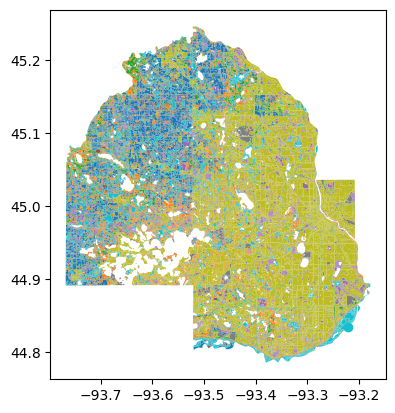

In [11]:
hennepin.plot(column='CARTO')

# NLCD and ESA

In [78]:
js = json.loads(shape.to_json())
roi = ee.Geometry(ee.FeatureCollection(js).geometry())
#roi = ee.Geometry.Point([-93.3, 45]).buffer(5000)

dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2021_REL/NLCD')\
            .filter(ee.Filter.eq('system:index', '2021'))\
            .filterBounds(roi)\
            .first()\
            .select('landcover')

dataset2 = ee.ImageCollection('ESA/WorldCover/v200')\
            .filter(ee.Filter.eq('system:index', '2021'))\
            .filterBounds(roi)\
            .first()\
            .select('Map')

In [51]:
dataset.projection().getInfo()

{'type': 'Projection',
 'wkt': 'PROJCS["Albers_Conical_Equal_Area", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Albers_Conic_Equal_Area"], \n  PARAMETER["central_meridian", -96.0], \n  PARAMETER["latitude_of_origin", 23.0], \n  PARAMETER["standard_parallel_1", 29.5], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  PARAMETER["standard_parallel_2", 45.5], \n  UNIT["m", 1.0], \n  AXIS["Easting", EAST], \n  AXIS["Northing", NORTH]]',
 'transform': [30, 0, -2493045, 0, -30, 3310005]}

In [79]:
geemap.download_ee_image_collection(
    ee.ImageCollection(dataset.clip(roi).reproject(crs='EPSG:4326', scale=30)), "./data", filenames=['nlcd'], scale=30
)
geemap.download_ee_image_collection(
    ee.ImageCollection(dataset2.clip(roi)), "./data", filenames=['esa'], scale=30
)

Total number of images: 1



nlcd.tif: |                    | 0.00/3.76M (raw) [  0.0%] in 00:00 (eta:     ?)

Total number of images: 1



esa.tif: |                     | 0.00/3.76M (raw) [  0.0%] in 00:00 (eta:     ?)

In [3]:
NLCD_old_classes = {
    0: 'None',
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    51: 'Dwarf Scrub',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    72: 'Sedge/Herbaceous',
    73: 'Lichens',
    74: 'Moss',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetland',
}
NLCD_new_clusters = {
    'None': 'None',
    'Open Water': 'None',
    'Perennial Ice/Snow': 'None', 
    'Developed, Open Space': 'Sparsely vegetated',
    'Developed, Low Intensity': 'Sparsely vegetated',
    'Developed, Medium Intensity': 'Urban',
    'Developed, High Intensity': 'Urban',
    'Barren Land (Rock/Sand/Clay)': 'None',
    'Deciduous Forest': 'Forest',
    'Evergreen Forest': 'Forest',
    'Mixed Forest': 'Forest',
    'Dwarf Scrub': 'Shrub',
    'Shrub/Scrub': 'Shrub',
    'Grassland/Herbaceous': 'Grassland',
    'Sedge/Herbaceous':'Grassland',
    'Lichens': 'Heathland',
    'Moss': 'Heathland',
    'Pasture/Hay': 'Agro',
    'Cultivated Crops': 'Agro', 
    'Woody Wetlands': 'Wetland',
    'Emergent Herbaceous Wetland': 'Wetland',
}

standard = {
    'None': 0,
    'Agro': 1,
    'Forest': 2,
    'Shrub': 3,
    'Wetland': 4,
    'Grassland': 5,
    'Urban': 6,
    'Sparsely vegetated': 7,
    'Heathland': 8,
}

old_to_new = {
    key: NLCD_new_clusters.get(value, None)  
    for key, value in NLCD_old_classes.items()
}

In [4]:
ESA = {
    10: 	'Forest',#006400 	Tree cover
    20: 	'None',#ffbb22 	Shrubland
    30: 	'Grassland',#ffff4c 	Grassland
    40: 	'Agro',#f096ff 	Cropland
    50: 	'Urban',#fa0000 	Built-up
    60: 	'Sparsely vegetated',#b4b4b4 	Bare / sparse vegetation
    70: 	'None',#f0f0f0 	Snow and ice
    80: 	'None',#0064c8 	Permanent water bodies
    90: 	'Wetland',#0096a0 	Herbaceous wetland
    95: 	'None',#00cf75 	Mangroves
    100: 	'None',#fae6a0 	Moss and lichen
}

standard = {
    'None': 0,
    'Agro': 1,
    'Forest': 2,
    'Shrub': 3,
    'Wetland': 4,
    'Grassland': 5,
    'Urban': 6,
    'Sparsely vegetated': 7,
    'Heathland': 8,
}

to_standard_esa = {
    key: standard.get(value, None)  
    for key, value in ESA.items()
}

In [82]:
raster = rxr.open_rasterio("./data/nlcd.tif")

img = raster[0]

reclassified_img = img.copy()

for old_class, new_class in old_to_new.items():
    reclassified_img = reclassified_img.where(img != old_class, new_class)

standardized_img = img.copy()
for category, std_value in standard.items():
    standardized_img = standardized_img.where(reclassified_img != category, std_value)
    nlcd = standardized_img.copy()
    
raster = rxr.open_rasterio("./data/esa.tif")

img = raster[0]

standardized_img = img.copy()
for category, std_value in to_standard_esa.items():
    standardized_img = standardized_img.where(standardized_img != category, std_value)
    esa = standardized_img.copy()

In [83]:
nlcd.rio.to_raster('nlcd_reclas.tif', dtype='int32')

In [84]:
esa.rio.to_raster('esa_reclas.tif', dtype='int32')

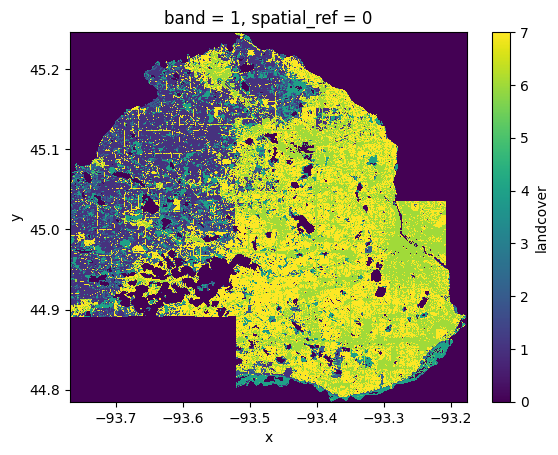

In [85]:
nlcd.astype(int).plot()

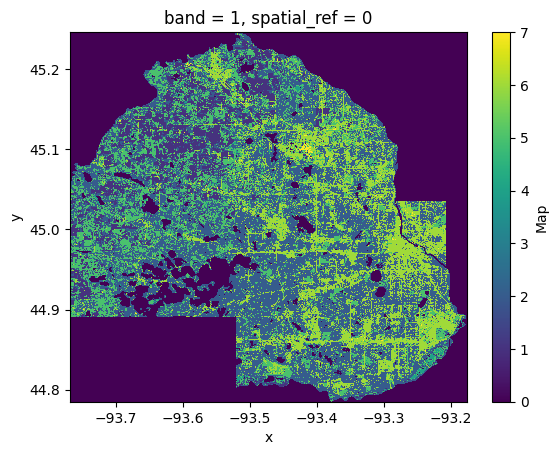

In [63]:
esa.astype(int).plot()

# Interface

In [3]:
import geemap.colormaps as cm
cm.palettes.keys()

dict_keys(['ndvi', 'ndwi', 'dem', 'dw', 'esri_lulc', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'coppe

In [95]:
standard

{'None': 0,
 'Agro': 1,
 'Forest': 2,
 'Shrub': 3,
 'Wetland': 4,
 'Grassland': 5,
 'Urban': 6,
 'Sparsely vegetated': 7,
 'Heathland': 8}

In [44]:
import matplotlib.colors as mcolors
custom_cmap = [
    (0, (0.0, 0.0, 0.0, 0.0)),            
    (1, 'yellow'),       
    (2, 'darkgreen'),      
    (3, 'green'),           
    (4, 'brown'),         
    (5, 'lime'),           
    (6, 'grey'),         
    (7, 'lightgrey'),     
    (8, 'lightgreen')    
]

colors = [color for value, color in custom_cmap if color != 'None']

discrete_cmap = mcolors.ListedColormap(colors)

In [4]:
import ipywidgets as widgets
from ipyleaflet import Map, DrawControl

In [18]:
clip_btn = widgets.BoundedIntText(
    value=7,
    min=0,
    max=10,
    step=1,
    description='Class',
    disabled=False
)
reset_btn = widgets.Button(description="Submit")

In [72]:
poly = shape.geometry.unary_union
js = json.loads(shape.to_json())
roi = ee.Geometry(ee.FeatureCollection(js).geometry())

m = geemap.Map()

widget = widgets.VBox([clip_btn, reset_btn])
m.add_widget(widget, position="bottomright")

m.set_center(poly.centroid.x, poly.centroid.y, 12)
m.add_basemap('Esri.WorldImagery')
m.add_layer(roi, {'color':'white'}, 'Hennepin')
m.add_raster('nlcd_reclas.tif',colormap=discrete_cmap)

m.to_html('map.html')
m

Map(center=[45.00460011033634, -93.47693200290367], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
m.to_html('map.html')

In [74]:
def geojson_to_shapely(drawn_features):
    shapely_geometries = []
    for feature in drawn_features:
        geometry = feature.getInfo()['geometry']
        coords = geometry['coordinates']
        if geometry['type'] == 'Polygon':
            shapely_geometries.append(shapely.geometry.Polygon(coords[0]))
    return shapely_geometries

In [75]:
drawn_features = m.draw_features #draw_last_feature
polygons = geojson_to_shapely(drawn_features)

In [76]:
raster = rxr.open_rasterio("nlcd_reclas.tif")

gdf = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:4326")  # Define CRS (WGS84)
gdf = gdf.to_crs("EPSG:4326")

In [82]:
transform = raster.rio.transform()  # Get the affine transform for the raster
out_shape = (raster.shape[1], raster.shape[2])  # Get the shape of the raster (height, width)
gdf = gdf.to_crs("EPSG:4326")
raster.rio.write_crs("EPSG:4326", inplace=True)
shapes = [shapes for shapes in gdf.geometry]
shapes

[<POLYGON ((-93.624 45.041, -93.624 45.114, -93.444 45.114, -93.444 45.041, -...>]

In [92]:
transform = raster.rio.transform()  # Get the affine transform for the raster
out_shape = (raster.shape[1], raster.shape[2])  # Get the shape of the raster (height, width)
gdf = gdf.to_crs("EPSG:4326")
raster.rio.write_crs("EPSG:4326", inplace=True)
shapes = [shapes for shapes in gdf.geometry]
rasterized_mask = rasterio.features.rasterize(
    shapes, 
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)
rasterized_mask = np.where((raster[0] != 0), rasterized_mask, 0)

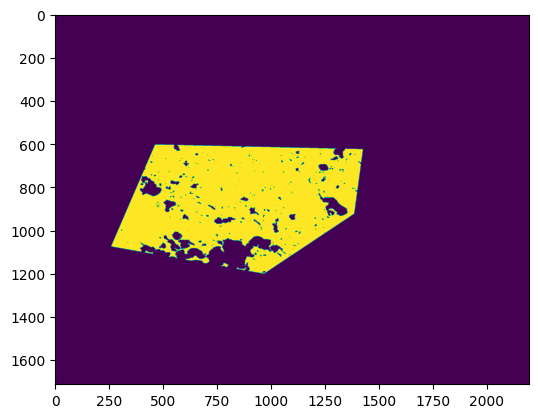

In [9]:
plt.imshow(np.where((raster[0] != 0), rasterized_mask, 0))

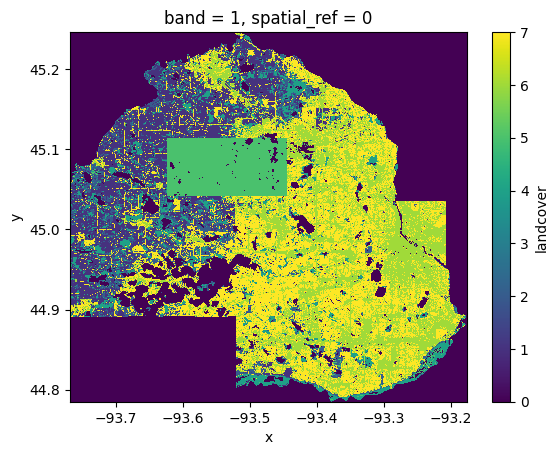

In [93]:
masked = raster[0].where(rasterized_mask==0, other=5)
masked.plot()

# Sequestration and Storage

In [11]:
standard = {
    'None': 0,
    'Agro': 1,
    'Forest': 2,
    'Shrub': 3,
    'Wetland': 4,
    'Grassland': 5,
    'Urban': 6,
    'Sparsely vegetated': 7,
    'Heathland': 8,
}
standard_r = {v: k for k, v in standard.items()}

In [88]:
def recursive_wrapper(data, initial_depth): #depth 0-7
    l = [None]*(initial_depth+1)
    D, k = {}, 0
    def recursive(data, depth):
        nonlocal l 
        nonlocal k
        if depth > -1:
            sub = data[depth]
            depth -= 1
            for index, row in sub.iterrows():
                l[depth+1] = row
                if depth == -1 and len(l) == len(data):
                    D[k] = pd.DataFrame(l.copy())
                    k+=1
                recursive(data, depth)

    recursive(data, initial_depth)
    return D

def count_unique_dfs(dfs):
    unique_dfs = set()
    
    for key, df in dfs.items():
        # Convert DataFrame to a tuple of tuples (hashable)
        df_tuple = tuple(map(tuple, df.to_numpy()))
        unique_dfs.add(df_tuple)
    
    return len(unique_dfs)

In [89]:
for i in range(1,4):
    if 'df' not in globals():
        df = pd.read_csv(f'./data/Inventory_{i}.csv')
    else:
        df_new = pd.read_csv(f'./data/Inventory_{i}.csv')
        df = pd.concat([df, df_new]).reset_index(drop=True)
data=[]
for label, group in df.groupby('land_cover'):
    data.append(group)

In [94]:
nlcd_pixels = masked.values.flatten()
nlcd_pixels_before = raster[0].values.flatten()

In [15]:
def count(nlcd_pixels):
    storages, seqs = [], []
    counted = Counter(nlcd_pixels)
    R = recursive_wrapper(data, 7)
    for i in range(len(R)):
        df=R[i]
        st, sq = 0, 0
        for key in counted:
            if key!=0:
                st+=counted[key]*df[df.land_cover==standard_r[key]].storage.item()
                sq+=counted[key]*df[df.land_cover==standard_r[key]].sequestration.item()
        st /= sum(counted.values())
        sq /= sum(counted.values())
        storages.append(st)
        seqs.append(sq)
        print(f'{i+1}/{len(R)}')
    return storages, seqs
storages, seqs = count(nlcd_pixels)
carbon_nlcd = pd.DataFrame(columns=['storage', 'sequestration'])
carbon_nlcd.storage = storages
carbon_nlcd.sequestration = seqs

storages, seqs = count(nlcd_pixels_before)
carbon_nlcd_before = pd.DataFrame(columns=['storage', 'sequestration'])
carbon_nlcd_before.storage = storages
carbon_nlcd_before.sequestration = seqs

1/243
2/243
3/243
4/243
5/243
6/243
7/243
8/243
9/243
10/243
11/243
12/243
13/243
14/243
15/243
16/243
17/243
18/243
19/243
20/243
21/243
22/243
23/243
24/243
25/243
26/243
27/243
28/243
29/243
30/243
31/243
32/243
33/243
34/243
35/243
36/243
37/243
38/243
39/243
40/243
41/243
42/243
43/243
44/243
45/243
46/243
47/243
48/243
49/243
50/243
51/243
52/243
53/243
54/243
55/243
56/243
57/243
58/243
59/243
60/243
61/243
62/243
63/243
64/243
65/243
66/243
67/243
68/243
69/243
70/243
71/243
72/243
73/243
74/243
75/243
76/243
77/243
78/243
79/243
80/243
81/243
82/243
83/243
84/243
85/243
86/243
87/243
88/243
89/243
90/243
91/243
92/243
93/243
94/243
95/243
96/243
97/243
98/243
99/243
100/243
101/243
102/243
103/243
104/243
105/243
106/243
107/243
108/243
109/243
110/243
111/243
112/243
113/243
114/243
115/243
116/243
117/243
118/243
119/243
120/243
121/243
122/243
123/243
124/243
125/243
126/243
127/243
128/243
129/243
130/243
131/243
132/243
133/243
134/243
135/243
136/243
137/243
138/243
139/

In [16]:
carbon_nlcd.mean() * 44 / 12 * 156810 / 1e6 # million T CO2e yr-1

storage          22.146793
sequestration     1.102980
dtype: float64

In [17]:
carbon_nlcd_before.mean() * 44 / 12 * 156810 / 1e6 # million T CO2e yr-1

storage          24.707479
sequestration     0.504846
dtype: float64

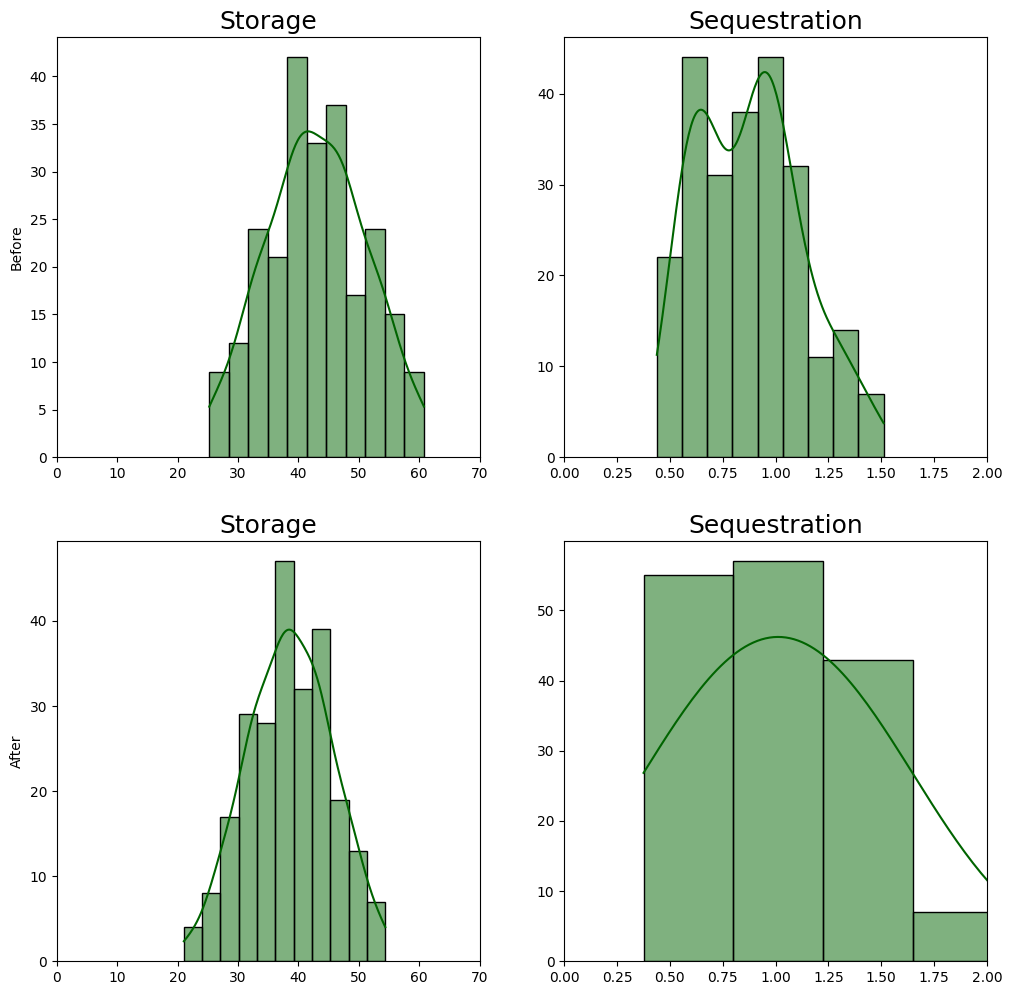

In [18]:
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.histplot(data=carbon_nlcd_before, x="storage", kde=True, ax=ax[0][0], color='darkgreen')
sns.histplot(data=carbon_nlcd_before, x="sequestration", kde=True, ax=ax[0][1], color='darkgreen')

ax[0][0].set_title('Storage', fontsize=18)
ax[0][1].set_title('Sequestration', fontsize=18)
ax[0][0].set_xlabel('')
ax[0][1].set_xlabel('')
ax[0][0].set_ylabel('Before')
ax[0][1].set_ylabel('')
ax[0][0].set_xlim(0,70)
ax[0][1].set_xlim(0, 2)

sns.histplot(data=carbon_nlcd, x="storage", kde=True, ax=ax[1][0], color='darkgreen')
sns.histplot(data=carbon_nlcd, x="sequestration", kde=True, ax=ax[1][1], color='darkgreen')

ax[1][0].set_title('Storage', fontsize=18)
ax[1][1].set_title('Sequestration', fontsize=18)
ax[1][0].set_xlabel('')
ax[1][1].set_xlabel('')
ax[1][0].set_ylabel('After')
ax[1][1].set_ylabel('')
ax[1][0].set_xlim(0,70)
ax[1][1].set_xlim(0, 2)


plt.show()

# Folium experiment

In [34]:
raster = rxr.open_rasterio("nlcd_reclas.tif")
raster

<xarray.DataArray (band: 1, y: 1712, x: 2195)> Size: 15MB
[3757840 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 18kB -93.77 -93.77 -93.77 ... -93.18 -93.18 -93.18
  * y            (y) float64 14kB 45.25 45.25 45.25 45.25 ... 44.79 44.79 44.79
    spatial_ref  int64 8B 0
Attributes: (12/34)
    description:                                                             ...
    gsd:                                                                      30
    impervious_descriptor_class_names:                                       ...
    impervious_descriptor_class_palette:                                     ...
    impervious_descriptor_class_values:                                      ...
    landcover_class_names:                                                   ...
    ...                                                                       ...
    system-time_end:                                                         ...
    system-time_start:                                                       ...
    AREA_OR_POINT:                                                           ...
    _FillValue:                                                               0
    scale_factor:                                                            ...
    add_offset:                                                              ...

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

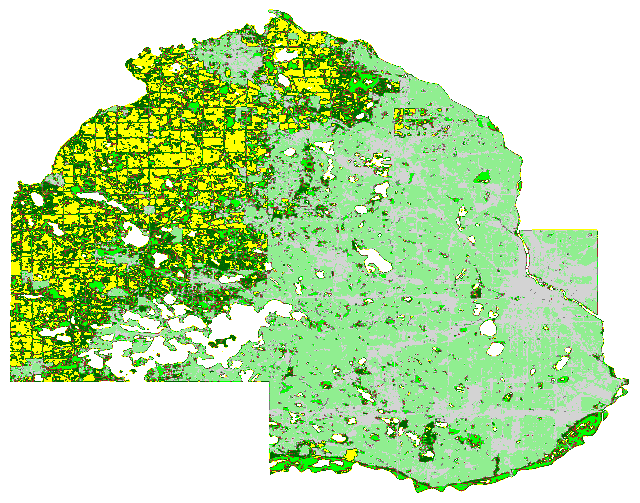

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(raster[0].to_numpy(), cmap=discrete_cmap)  # You can customize the colormap
ax.axis('off')  # Turn off axes for a cleaner image

# Save the image as PNG (Leaflet can use this)
png_path = './src/assets/nlcd.png'
plt.savefig(png_path, format='png', bbox_inches='tight', pad_inches=0, transparent=True, dpi=1200)

In [60]:
geojson = {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'type': 'polygon', '_bounds': [{'lat': 45.09824557777033, 'lng': -93.38104248046876}, {'lat': 45.13216438794409, 'lng': -93.34259033203126}], '_leaflet_id': 134}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-93.38104248046876, 45.11133093583217], [-93.36044311523439, 45.09824557777033], [-93.34259033203126, 45.13216438794409], [-93.36524963378908, 45.13119555886255], [-93.38104248046876, 45.11133093583217]]]}}]}
geojson['features'][0]

{'type': 'Feature',
 'properties': {'type': 'polygon',
  '_bounds': [{'lat': 45.09824557777033, 'lng': -93.38104248046876},
   {'lat': 45.13216438794409, 'lng': -93.34259033203126}],
  '_leaflet_id': 134},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-93.38104248046876, 45.11133093583217],
    [-93.36044311523439, 45.09824557777033],
    [-93.34259033203126, 45.13216438794409],
    [-93.36524963378908, 45.13119555886255],
    [-93.38104248046876, 45.11133093583217]]]}}

In [68]:
for i, sh in enumerate([shapely.geometry.Polygon(geojson['features'][0]['geometry']['coordinates'][0])]):
    print(i, sh)

0 POLYGON ((-93.38104248046876 45.11133093583217, -93.36044311523439 45.09824557777033, -93.34259033203126 45.13216438794409, -93.36524963378908 45.13119555886255, -93.38104248046876 45.11133093583217))
